# Introduction

This notebook explores a machine-learning approach to option hedging. Using simulated price and volatility paths—typically from the Heston model—we train a neural network to estimate hedge ratios that minimise hedging error. The learned strategy is then evaluated in a full hedging simulation and compared with standard approaches such as Black–Scholes delta hedging. The objective is to demonstrate how data-driven methods can adapt to richer market dynamics and improve hedge performance under realistic conditions.


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import norm


import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))
from hedging import DeltaTrainer, HedgingSimulator, black_scholes_delta
from heston_mc import HestonMonteCarloPricer



### Generating the Training Dataset

We create an instance of `DeltaTrainer` and use it to generate synthetic option data based on randomly sampled market parameters. The resulting feature matrix `X` and target deltas `y` are then divided into training and test sets using an 80/20 split to allow out-of-sample evaluation.



In [3]:
trainer = DeltaTrainer()
X, y = trainer.generate_training_data()

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

### Training and Evaluating the Delta Model

The neural network is trained on the synthetic option dataset, after which its performance is assessed on the test set. The root-mean-square error (RMSE) quantifies how closely the model replicates the analytical Black–Scholes delta. A scatter plot compares predicted deltas with the true values, with the diagonal line indicating perfect agreement.



Delta RMSE = 0.0511


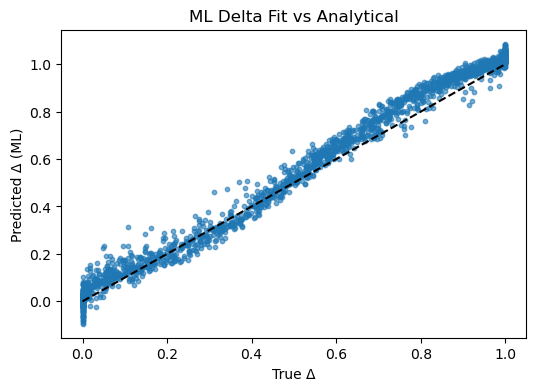

In [4]:
trainer.train(X_train, y_train)
rmse, y_pred = trainer.evaluate(X_test, y_test)
print(f"Delta RMSE = {rmse:.4f}")

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("True Δ")
plt.ylabel("Predicted Δ (ML)")
plt.title("ML Delta Fit vs Analytical")
plt.show()

### Hedging Simulation Under the Heston Model

To assess the effectiveness of the analytical and machine-learning deltas, we run a hedging simulation using Heston-model price paths. The `HedgingSimulator` applies each delta rule along the path and computes the resulting hedging P&L. By repeating this over many scenarios, we obtain distributions for both approaches and compare their variances as a measure of hedge quality.



In [5]:
pricer = HestonMonteCarloPricer(n_paths=2000, n_steps=252)
simulator = HedgingSimulator(pricer)

def analytical_delta(S, K, T):
    return black_scholes_delta(S, K, T, r=0.01, sigma=0.2)

def ml_delta(S, K, T):
    return trainer.model.predict(np.array([[S, K, T, 0.01, 0.2]]))[0]


pnl_analytical = [simulator.simulate(analytical_delta) for _ in range(500)]
pnl_ml = [simulator.simulate(ml_delta) for _ in range(500)]

df = pd.DataFrame({"Analytical": pnl_analytical, "ML": pnl_ml})
print("P&L Variance Comparison:")
print(df.var())

P&L Variance Comparison:
Analytical    5.456039
ML            8.164831
dtype: float64


### Hedging Performance Visualisation

We compare the hedging outcomes from the analytical and machine-learning deltas by examining the distribution of P&L across simulated scenarios. The histograms show the overall shape and dispersion of the P&L distributions, while the boxplot highlights differences in spread and central tendency. Lower variance indicates a more effective hedge.




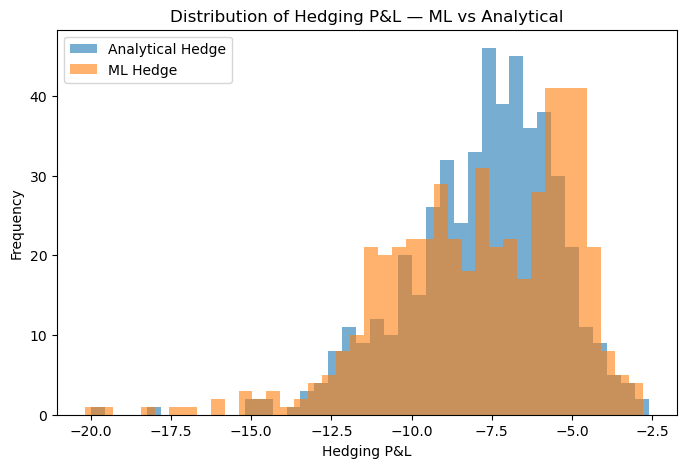

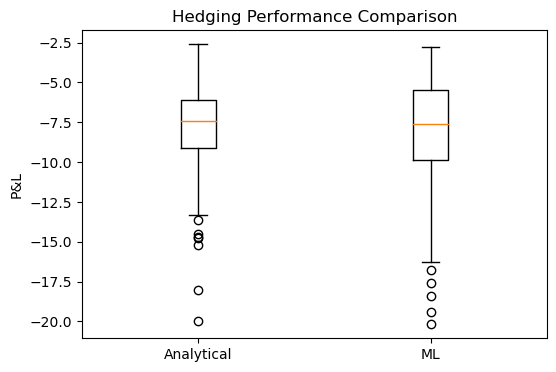

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(df["Analytical"], bins=40, alpha=0.6, label="Analytical Hedge")
plt.hist(df["ML"], bins=40, alpha=0.6, label="ML Hedge")
plt.xlabel("Hedging P&L")
plt.ylabel("Frequency")
plt.title("Distribution of Hedging P&L — ML vs Analytical")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot([df["Analytical"], df["ML"]], labels=["Analytical", "ML"])
plt.ylabel("P&L")
plt.title("Hedging Performance Comparison")
plt.show()